In [44]:
import os

# Get current working directory
print("Current directory:", os.getcwd())

# Change to a new directory
new_dir = "/Users/sqwu/property_api/property_api"
os.chdir(new_dir)

# Verify the change
print("New directory:", os.getcwd())

Current directory: /Users/sqwu/property_api/property_api
New directory: /Users/sqwu/property_api/property_api


In [45]:
import pandas as pd
import plotly.express as px
from src.database import db
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [72]:
def load_data():
    # Example: Fetch from SQLite, CSV, or API
    database = db.SessionLocal()
    data = database.query(db.FlatsToRent).all()
    df = pd.DataFrame([task.__dict__ for task in data])
    df = df.drop(columns=["_sa_instance_state"], axis=1)
    return df

def create_heatmap_data(df: pd.DataFrame,
                        index: str,
                        column: str,
                        value: str):
    """Generate two pivot tables: counts and avg prices"""
    count_pivot = df.pivot_table(
        index=index, #'number_of_bedroom',
        columns=column, #'number_of_bathroom',
        values=value, #'price',
        aggfunc='count',
        fill_value=0
    ).sort_index(ascending=False)
    
    price_pivot = df.pivot_table(
        index=index, #'number_of_bedroom',
        columns=column, #'number_of_bathroom',
        values=value, #'price',
        aggfunc='mean',
        fill_value=0
    ).sort_index(ascending=False)
    
    return count_pivot, price_pivot

def price_dist(df, zone, fig, ax):
    df_plot = df[df['location'] == zone]
    mean = df_plot['price'].mean()
    min = int(df['price'].max())
    max = int(df['price'].min())
    
    # Define your fixed range
    PRICE_RANGE = [max, min]
    N_BINS = 40  # Adjust bin count as needed
    
    # Create bins equally spaced across the fixed range
    bins = np.linspace(max, min, N_BINS+1)
    
    # Plot histogram with fixed bins
    ax.hist(df_plot['price'], bins=bins, color='#FF4B4B', alpha=0.5)
    
    # Force x-axis limits
    ax.set_xlim(PRICE_RANGE)
    
    # Add mean line and label
    ax.axvline(mean, color='green', linestyle='--')
    ax.text(mean, ax.get_ylim()[1]*0.9, f'Mean: £{mean:.0f}',
            color='green', ha='center', fontsize=10)
    
    # Labels and title
    ax.set_xlabel('Monthly Rent (£)')
    ax.set_ylabel('Number of Properties')
    ax.set_title(f'Price distribution of {zone} (n={len(df_plot)})', fontsize=12, pad=10)
    
    # Add grid and clean up borders
    ax.grid(axis='y', alpha=0.3)
    for spine in ['top', 'right']:
        ax.spines[spine].set

In [47]:
df = load_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   property_type       223 non-null    object 
 1   unique_id           223 non-null    object 
 2   rent                223 non-null    object 
 3   price               223 non-null    int64  
 4   number_of_bedroom   223 non-null    int64  
 5   description         223 non-null    object 
 6   price_score         201 non-null    float64
 7   combined_score      201 non-null    float64
 8   address             223 non-null    object 
 9   location            223 non-null    object 
 10  base                223 non-null    object 
 11  number_of_bathroom  223 non-null    int64  
 12  link                223 non-null    object 
 13  confort_score       201 non-null    float64
 14  run_time            223 non-null    object 
dtypes: float64(3), int64(3), object(9)
memory usage: 26.3+ KB

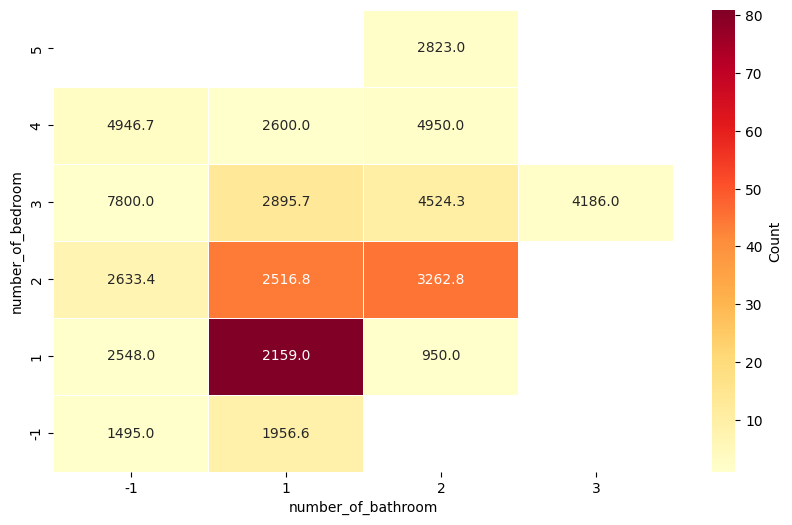

In [48]:
count_pivot, price_pivot = create_heatmap_data(df,
                                               index = 'number_of_bedroom',
                                               column = 'number_of_bathroom',
                                               value = 'price')

# Create the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    count_pivot,  # Color scale based on avg price
    annot=price_pivot,  # Cell text shows property count
    fmt=".1f",  # Display counts as integers
    cmap="YlOrRd",
    linewidths=.5,
    cbar_kws={'label': 'Count'},
    mask=(count_pivot == 0)  # Hide cells with zero properties
)

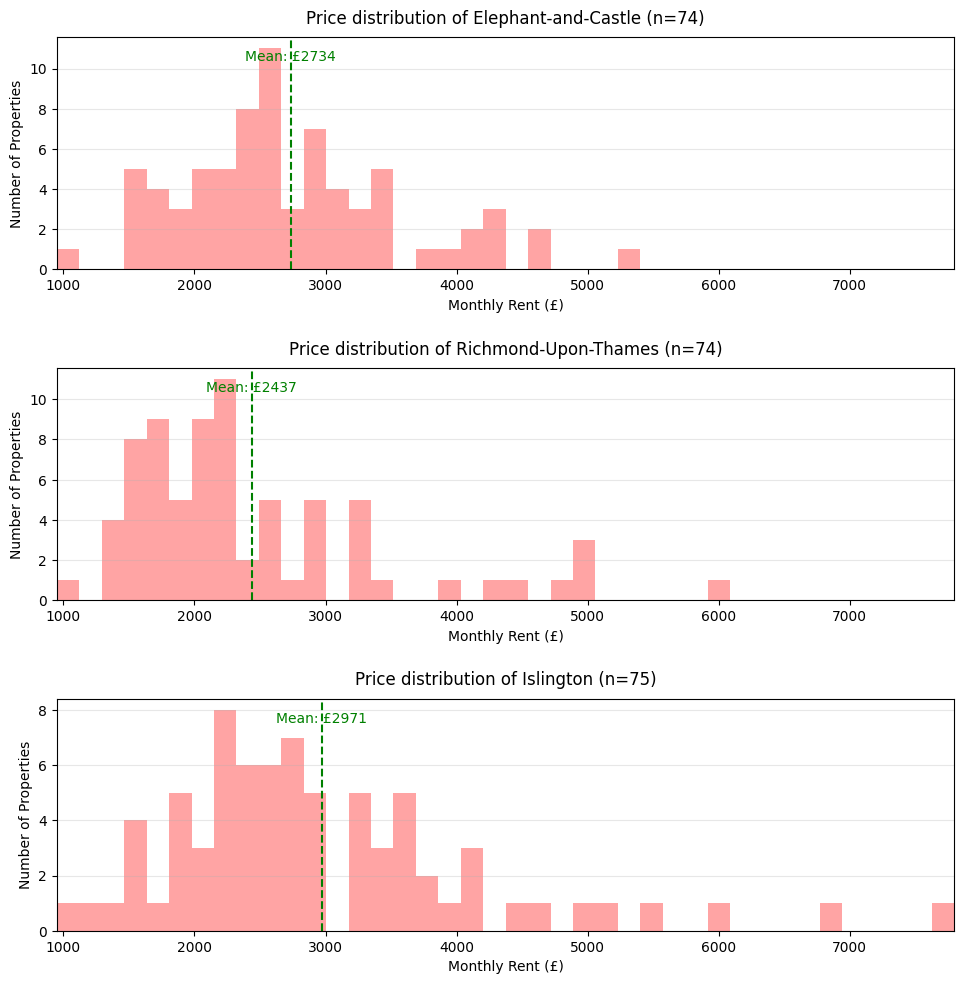

In [81]:
# Create figure
location_list = df['location'].unique()
num_loc = len(location_list)
fig, ax_list = plt.subplots(num_loc, 1, figsize=(10, num_loc*3.4), dpi=100)

for i in range(num_loc):
    loc = location_list[i]
    ax = ax_list[i]
    price_dist(df, loc, fig, ax)
plt.tight_layout(pad=2.0)

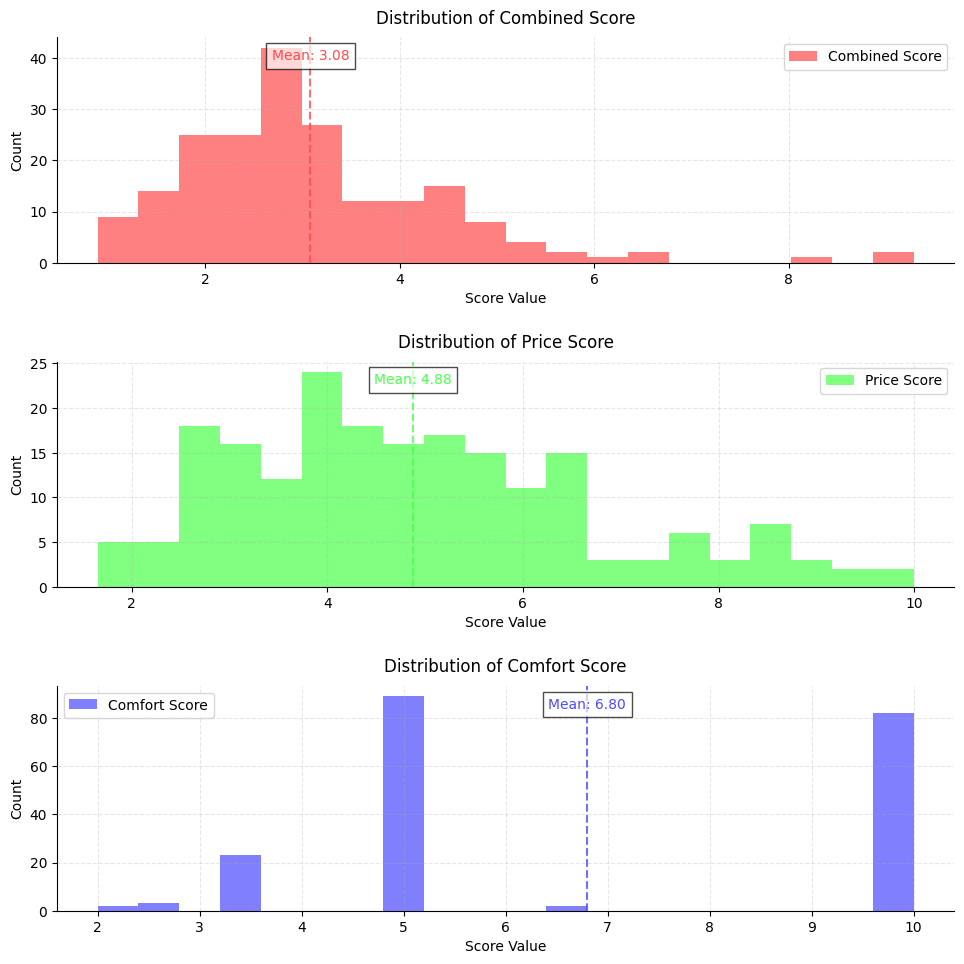

In [80]:
# Create a figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), dpi=100)

# Data to plot
scores = {
    'Combined Score': df['combined_score'],
    'Price Score': df['price_score'],
    'Comfort Score': df['confort_score']
}

colors = {
    'Combined Score': '#FF4B4B',
    'Price Score': '#4BFF4B',
    'Comfort Score': '#4B4BFF'
}

# Plot each histogram in its own subplot
for ax, (name, data) in zip([ax1, ax2, ax3], scores.items()):
    # Plot histogram
    ax.hist(data, bins=20, color=colors[name], alpha=0.7, label=name)
    
    # Add mean line and text
    mean = data.mean()
    ax.axvline(mean, color=colors[name], linestyle='--', linewidth=1.5, alpha=0.8)
    ax.text(mean, ax.get_ylim()[1]*0.9, f'Mean: {mean:.2f}',
            color=colors[name], ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
    
    # Customize each subplot
    ax.set_xlabel('Score Value', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'Distribution of {name}', fontsize=12, pad=10)
    ax.grid(True, linestyle='--', alpha=0.3)
    
    # Remove top/right spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    
    # Add legend
    ax.legend()

# Adjust layout and spacing
plt.tight_layout(pad=2.0)
plt.show()

heatmap: price score x comfort score

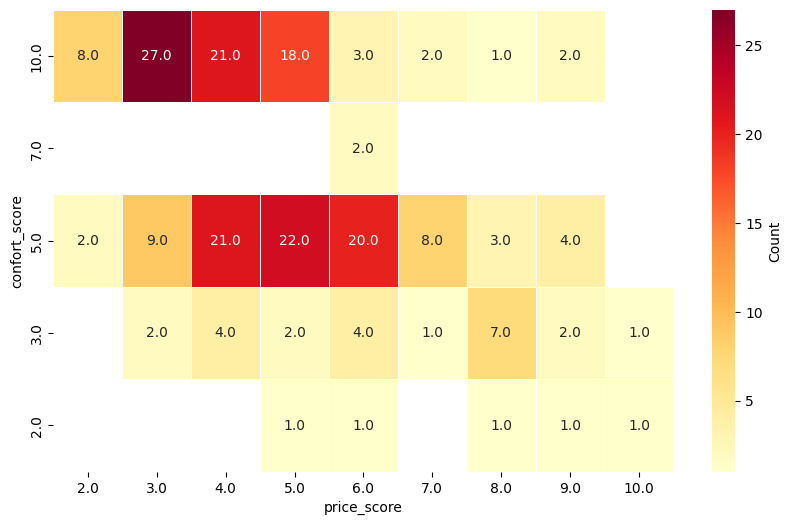

In [52]:
df_plot = df.copy()
df_plot['price_score'] = df_plot['price_score'].round(0) 
df_plot['confort_score'] = df_plot['confort_score'].round(0) 

count_pivot, price_pivot = create_heatmap_data(df_plot,
                                               index = 'confort_score',
                                               column = 'price_score',
                                               value = 'price')

# Create the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(
    count_pivot,  # Color scale based on avg price
    annot=count_pivot,  # Cell text shows property count
    fmt=".1f",  # Display counts as integers
    cmap="YlOrRd",
    linewidths=.5,
    cbar_kws={'label': 'Count'},
    mask=(count_pivot == 0)  # Hide cells with zero properties
)

In [53]:
display(df.sort_values('combined_score', ascending=False).head(10))

,property_type,unique_id,rent,price,number_of_bedroom,description,price_score,combined_score,address,location,base,number_of_bathroom,link,confort_score,run_time
152,Flat Share,5E939651|5|2025-06-09|11:11:45.081527,£975 pcm,975,1,*ALL BILLS INCLUDED* A spaciously furnished do...,9.285284,9.285284,"Cottenham House, London, N19",Islington,pcm,1,https://www.rightmove.co.uk/properties/1585946...,10.0,2025-06-09
1,Flat Share,5E703121|2|2025-06-07|12:28:25.200687,£950 pcm,950,1,Beautiful double room with leafy views in Elep...,9.200805,9.200805,"Orb Street, Elephant And Castle, SE17",Elephant-and-Castle,pcm,2,https://www.rightmove.co.uk/properties/1628101...,10.0,2025-06-07
186,Apartment,5E939652|14|2025-06-09|11:11:45.081527,"£1,175 pcm",1175,1,No Further Enquiries Being Taken Due To Intere...,8.356898,8.356898,"Annette Road, London, N7",Islington,pcm,1,https://www.rightmove.co.uk/properties/1629815...,10.0,2025-06-09
185,Flat,5E939652|13|2025-06-09|11:11:45.081527,"£1,500 pcm",1500,1,Bright and spacious furnished 1-bedroom apartm...,6.538377,6.538377,"Hornsey Road, \nHolloway, N19",Islington,pcm,1,https://www.rightmove.co.uk/properties/1627423...,10.0,2025-06-09
176,Apartment,5E939652|4|2025-06-09|11:11:45.081527,"£1,500 pcm",1500,1,One bedroom flat to rent on Hornsey Road. This...,6.538377,6.538377,"Hornsey Road, Finsbury Park, London",Islington,pcm,1,https://www.rightmove.co.uk/properties/1620088...,10.0,2025-06-09
151,Flat,5E939651|4|2025-06-09|11:11:45.081527,"£1,560 pcm",1560,1,This well-presented one-bedroom flat is ideall...,6.220391,6.220391,"Holloway Road, London, N19",Islington,pcm,1,https://www.rightmove.co.uk/properties/1624326...,10.0,2025-06-09
51,Apartment,5E703123|3|2025-06-07|12:28:25.200687,"£1,600 pcm",1600,1,"One Bedroom Flat, Walworth",5.532100,5.532100,"Portland Street, London",Elephant-and-Castle,pcm,1,https://www.rightmove.co.uk/properties/1609549...,10.0,2025-06-07
33,Flat,5E703122|10|2025-06-07|12:28:25.200687,"£1,600 pcm",1600,1,"Refurbished 1 bed, 1 bath apartment in Walwort...",5.532100,5.532100,"Portland Street, Walworth Village",Elephant-and-Castle,pcm,1,https://www.rightmove.co.uk/properties/1629508...,10.0,2025-06-07
190,Apartment,5E939652|18|2025-06-09|11:11:45.081527,"£1,712 pcm",1712,1,"A spacious, one double bedroom apartment with ...",5.479727,5.479727,"Bryan street, London N1",Islington,pcm,1,https://www.rightmove.co.uk/properties/1629778...,10.0,2025-06-09
56,Apartment,5E703123|8|2025-06-07|12:28:25.200687,"£1,625 pcm",1625,1,"One Bedroom Flat, Walworth",5.407871,5.407871,"Portland Street, London",Elephant-and-Castle,pcm,1,https://www.rightmove.co.uk/properties/1628632...,10.0,2025-06-07
